In [1]:
# dataframe and series 
import pandas as pd
import numpy as np

# sklearn imports for modeling part
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

# XGBoost and LGBM classifier imports
import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv("/kaggle/input/data-work/data_work")
data['reviewText']=data['reviewText'].str.lower()
import string
string.punctuation 
def remove_punctuation(text):
    '''this function splits the words to letters, remove punctuation and 
        again getting together letters as words '''
    text_no_punc = "".join([c for c in text if c not in string.punctuation])
    return text_no_punc
data['review_clean'] = data['reviewText'].apply(lambda x: remove_punctuation(x))
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,review_clean
0,5.0,True,"11 9, 2012",A2M1CU2IRZG0K9,0005089549,{'Format:': ' VHS Tape'},Terri,so sorry i didn't purchase this years ago when...,Amazing!,1352419200,so sorry i didnt purchase this years ago when ...
1,5.0,True,"12 30, 2011",AFTUJYISOFHY6,0005089549,{'Format:': ' VHS Tape'},Melissa D. Abercrombie,believe me when i tell you that you will recei...,Great Gospel VHS of the Cathedrals!,1325203200,believe me when i tell you that you will recei...
2,5.0,True,"04 21, 2005",A3JVF9Y53BEOGC,000503860X,{'Format:': ' DVD'},Anthony Thompson,"i have seen x live many times, both in the ear...",A great document of a great band,1114041600,i have seen x live many times both in the earl...
3,5.0,True,"04 6, 2005",A12VPEOEZS1KTC,000503860X,{'Format:': ' DVD'},JadeRain,"i was so excited for this! finally, a live co...",YES!! X LIVE!!,1112745600,i was so excited for this finally a live conc...
4,5.0,True,"12 3, 2010",ATLZNVLYKP9AZ,000503860X,{'Format:': ' DVD'},T. Fisher,x is one of the best punk bands ever. i don't ...,X have still got it,1291334400,x is one of the best punk bands ever i dont ev...


In [3]:
def calc_sentiment_with_neutral(overall):
    '''encoding the sentiments of the ratings.'''
    if overall == 5 or overall == 4:
        return 2
    elif overall == 1 or overall==2 : 
        return 0
    else:
        return 1
data['sentiment'] = data['overall'].apply(calc_sentiment_with_neutral)
data

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,review_clean,sentiment
0,5.0,True,"11 9, 2012",A2M1CU2IRZG0K9,0005089549,{'Format:': ' VHS Tape'},Terri,so sorry i didn't purchase this years ago when...,Amazing!,1352419200,so sorry i didnt purchase this years ago when ...,2
1,5.0,True,"12 30, 2011",AFTUJYISOFHY6,0005089549,{'Format:': ' VHS Tape'},Melissa D. Abercrombie,believe me when i tell you that you will recei...,Great Gospel VHS of the Cathedrals!,1325203200,believe me when i tell you that you will recei...,2
2,5.0,True,"04 21, 2005",A3JVF9Y53BEOGC,000503860X,{'Format:': ' DVD'},Anthony Thompson,"i have seen x live many times, both in the ear...",A great document of a great band,1114041600,i have seen x live many times both in the earl...,2
3,5.0,True,"04 6, 2005",A12VPEOEZS1KTC,000503860X,{'Format:': ' DVD'},JadeRain,"i was so excited for this! finally, a live co...",YES!! X LIVE!!,1112745600,i was so excited for this finally a live conc...,2
4,5.0,True,"12 3, 2010",ATLZNVLYKP9AZ,000503860X,{'Format:': ' DVD'},T. Fisher,x is one of the best punk bands ever. i don't ...,X have still got it,1291334400,x is one of the best punk bands ever i dont ev...,2
...,...,...,...,...,...,...,...,...,...,...,...,...
399995,5.0,True,"08 31, 2017",A2RCR40SNWKRH7,B00065W99Y,{'Size Name:': ' 1 Gallon'},The Dirt Guy,i used this cleaner as part of the first step ...,Amazing Cleaner,1504137600,i used this cleaner as part of the first step ...,2
399996,3.0,True,"03 21, 2016",A2C8BZOZKGW57H,B000VK4Q4K,{'Style:': ' 85-Lumen'},Joel C.,the flashlight is fairly cheaply made and i ha...,Once installed it worked great.,1458518400,the flashlight is fairly cheaply made and i ha...,1
399997,5.0,True,"11 4, 2017",A3QX3TEN2FS31K,B000I97FHY,{'Color:': ' white'},LEROY A DUCK,does what its suppose to.,Works well,1509753600,does what its suppose to,2
399998,5.0,True,"05 31, 2015",A1QZU5ZZJC5QYI,B0035YRCR2,{'Style:': ' Paddle On/Off Switch'},Rick C.,great,Five Stars,1433030400,great,2


In [4]:
def calc_two_sentiment(overall):
    '''This function encodes the rating 1 and 2 as 0, others as 1'''
    if overall >= 3:
        return 1
    else:
        return 0
data['sentiment'] = data['overall'].apply(calc_two_sentiment)
data['sentiment'].value_counts()

1    370010
0     29990
Name: sentiment, dtype: int64

In [5]:
data_0 = data.loc[data['sentiment']==0].head(50000)
data_1 = data.loc[data['sentiment']==1].head(50000)

In [6]:
frames = [data_0, data_1]
data_sampled = pd.concat(frames)

In [7]:
data_sampled

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,review_clean,sentiment
16,2.0,True,"05 2, 2014",A38KRRY00H5TEY,0005092663,{'Format:': ' VHS Tape'},Trish,while there was a lot of information in this p...,Lots of Info. But Mostly a Right-Wing Agenda P...,1398988800,while there was a lot of information in this p...,0
67,2.0,True,"12 29, 2016",A3BPS2OLX3B2TO,0005019281,{'Format:': ' Amazon Video'},SabinaDeMartini,"hate to say it, but this is an example of a re...",Stick with the classic version,1482969600,hate to say it but this is an example of a rem...,0
72,1.0,True,"12 28, 2016",A35VHR4L8HF3RQ,0005019281,{'Format:': ' Amazon Video'},kell,did not like,One Star,1482883200,did not like,0
89,2.0,True,"12 23, 2016",A1L2DLWYRNHKDR,0005019281,{'Format:': ' Amazon Video'},Yiannis P,pathetic reproduction of the dickens classic. ...,Don't Bother: Read the News,1482451200,pathetic reproduction of the dickens classic i...,0
95,1.0,True,"12 20, 2016",A1A0ZTO3NSSQ1O,0005019281,{'Format:': ' Amazon Video'},TocyRN,slow moving. boring. never finished it.,Boring. Never finished it,1482192000,slow moving boring never finished it,0
...,...,...,...,...,...,...,...,...,...,...,...,...
53849,5.0,True,"05 6, 2016",A3RIYMWJX6BLPT,0792146433,{'Format:': ' Amazon Video'},Michael Casey,every season just gets better and better. i l...,Five Stars,1462492800,every season just gets better and better i lo...,1
53850,5.0,True,"05 6, 2016",A219HTR7936G41,0792146433,{'Format:': ' Amazon Video'},shelley,"great, love it",Five Stars,1462492800,great love it,1
53851,5.0,True,"05 1, 2016",A2OT9HBPDR1UW6,0792146433,{'Format:': ' DVD'},Katherine Schwarz,excellent series,Five Stars,1462060800,excellent series,1
53852,5.0,True,"04 30, 2016",A1MM6PU8E3VZ5L,0792146433,{'Format:': ' DVD'},"A. Nathaniel Wallace, Jr.",the fifth season of star trek deep space nine ...,The Best Season Thus Far Minus The New Uniforms!,1461974400,the fifth season of star trek deep space nine ...,1


### Теперь посмотрим на модели машинного обучения
Первым идет обычный классификатор на основе логистической регрессии

In [8]:
def model_split(df) :
    '''This function splits data to train and test, then vectorized reviews '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], 
                                                        df['sentiment'], test_size=0.2, random_state=42)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['review_clean'])
    
    # train - test vectorized features - tranforming to suitable format for modeling
    train_word_features = word_vectorizer.transform(X_train) 
    test_word_features = word_vectorizer.transform(X_test)
    
    return train_word_features , test_word_features, y_train, y_test 

def model(df,classifier):
    '''this function gives modeling results and confusion matrix also'''
    train_word_features,test_word_features,y_train,y_test = model_split(df)
    classifier.fit(train_word_features, y_train)
    
    # calculating results 
    y_pred_train = classifier.predict(train_word_features)
    y_pred = classifier.predict(test_word_features)
    
    #for smart printing (learned from our lead instructor Bryan Arnold)
    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
    print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {balanced_accuracy_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()


(63992,)
(15998,)
Accuracy:
TRAIN: 0.9036442055256907
TEST: 0.8902987873484186

Balanced Accuracy:
TRAIN: 0.9040826279079852
TEST: 0.8903353753794114


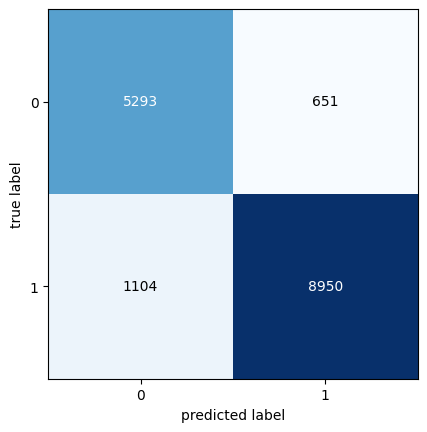

In [9]:
# выбор и запуск
classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
model(data_sampled,classifier)

In [10]:
# vectorize data for calculation
word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

word_vectorizer.fit(data_sampled['review_clean'])
    
word_features = word_vectorizer.transform(data_sampled['review_clean'])

scores = cross_val_score(classifier, word_features, data_sampled['sentiment'], cv=3, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8997289047368464 +/- 0.010724126024539888


Как видно значение близко к 1 что непременно хорошо.

## Классификатор дерева решений

(63992,)
(15998,)
Accuracy:
TRAIN: 0.6341886485810726
TEST: 0.6278909863732967

Balanced Accuracy:
TRAIN: 0.6377583361009042
TEST: 0.6309107133725527


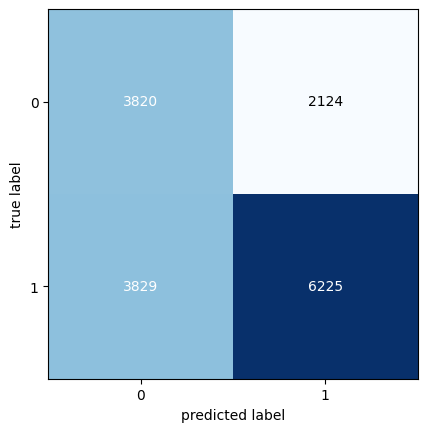

In [11]:
des_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                                        random_state=42, class_weight='balanced')
model(data_sampled,des_tree)

Здесь все довольно плохо и точность уже 63%

## Random Forest

(63992,)
(15998,)
Accuracy:
TRAIN: 0.9915770721340168
TEST: 0.8642955369421178

Balanced Accuracy:
TRAIN: 0.9898848234686818
TEST: 0.8475362584439718


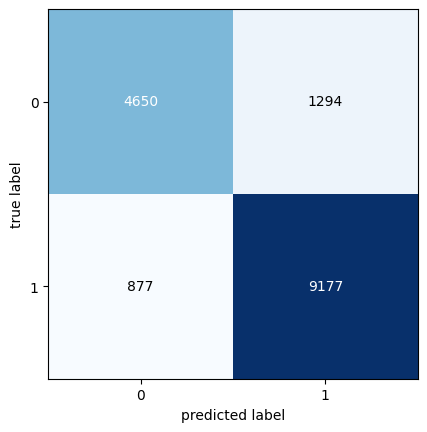

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced',
                            criterion = 'entropy',max_features = 'sqrt',min_samples_split = 5)
model(data_sampled,rf)

In [13]:
grid_p = {"n_estimators": [20, 50, 100],
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2'],
          "min_samples_split": [2, 5, 10]}

grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(word_features, data_sampled['sentiment'])


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              min_samples_split=5, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100]},
             scoring='roc_auc')

In [14]:
grid_search.best_score_

0.889786166143591

In [15]:
best_rf = grid_search.best_estimator_


In [16]:
best_rf

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', min_samples_split=10, n_jobs=-1,
                       random_state=42)

(63992,)
(15998,)
Accuracy:
TRAIN: 0.8173365420677585
TEST: 0.8118514814351794

Balanced Accuracy:
TRAIN: 0.8017378803229157
TEST: 0.795392314208523


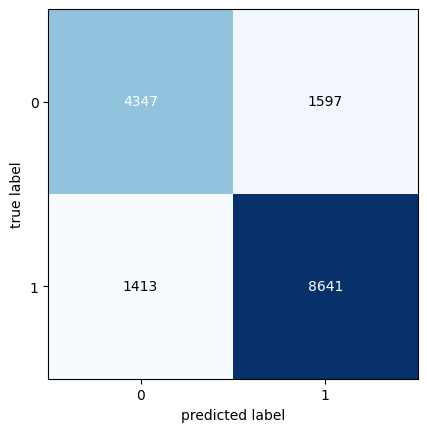

In [17]:
rf_extra = ExtraTreesClassifier(max_depth=5, criterion= 'entropy', min_samples_leaf=3, min_samples_split=18, 
                          random_state=42, n_estimators = 100, class_weight='balanced', n_jobs = -1)

model(data_sampled,rf_extra)

## XGBOOST Classifier 

(63992,)
(15998,)
[17:30:12] WARNING: ../src/learner.cc:767: 
Parameters: { "maximize", "nrounds" } are not used.

Accuracy:
TRAIN: 0.9599637454681835
TEST: 0.8642955369421178

Balanced Accuracy:
TRAIN: 0.9492680168547759
TEST: 0.8393865421475044


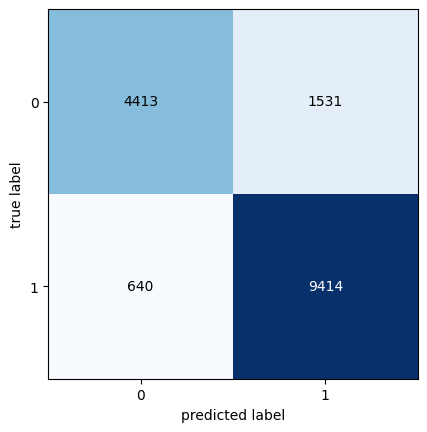

In [18]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror',
                        eta = .1,max_depth = 30, colsample_bytree = .4, learning_rate = 0.1,
                        max_delta_step=1)
model(data_sampled, xgb)

## LGBM Classifier

(63992,)
(15998,)
[LightGBM] [Warning] Unknown parameter: maximize
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
Accuracy:
TRAIN: 0.8552631578947368
TEST: 0.838104763095387

Balanced Accuracy:
TRAIN: 0.8239060226106875
TEST: 0.8039002073861712


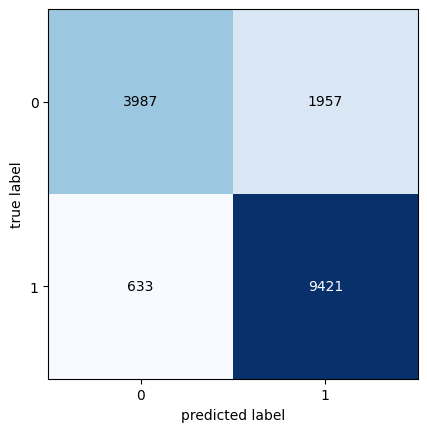

In [19]:
lgbm = LGBMClassifier(booster = 'gbtree', nrounds = 'min.error.idx', maximize = False,eta = .1,max_depth = 10, 
                      colsample_bytree = .4,learning_rate = 0.1,max_delta_step=1)
model(data_sampled, lgbm)

In [20]:
data_results = pd.DataFrame(columns=["Model", 'train_balanced', 'test_balanced'])
data_results = data_results.append({       # writing results to df
     "Model": 'Logreg' ,
               'train_balanced' : 0.90,
                    'test_balanced' : 0.89}, ignore_index=True)
data_results = data_results.append({       # writing results to df
     "Model": 'Decision Tree' ,
               'train_balanced' : 0.63,
                    'test_balanced' : 0.63}, ignore_index=True)
data_results = data_results.append({       # writing results to df
     "Model": 'Extra-Tree' ,
               'train_balanced' : 0.81,
                    'test_balanced' : 0.80}, ignore_index=True)
data_results = data_results.append({       # writing results to df
     "Model": 'Random Forest' ,
               'train_balanced' : 0.98,
                    'test_balanced' : 0.85}, ignore_index=True)
data_results = data_results.append({       # writing results to df
     "Model": 'XGBM' ,
               'train_balanced' : 0.94,
                    'test_balanced' : 0.83}, ignore_index=True)
data_results = data_results.append({       # writing results to df
     "Model": 'LGBM' ,
               'train_balanced' : 0.82,
                    'test_balanced' : 0.81}, ignore_index=True)

/tmp/ipykernel_20/2539052807.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_results = data_results.append({       # writing results to df
/tmp/ipykernel_20/2539052807.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_results = data_results.append({       # writing results to df
/tmp/ipykernel_20/2539052807.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_results = data_results.append({       # writing results to df
/tmp/ipykernel_20/2539052807.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_results = data_results.append({       # writing results to df
/tmp/ipykernel_20/2539052807.py:18: FutureWarning:

In [21]:
data_results

,Model,train_balanced,test_balanced
0,Logreg,0.90,0.89
1,Decision Tree,0.63,0.63
2,Extra-Tree,0.81,0.80
3,Random Forest,0.98,0.85
4,XGBM,0.94,0.83
5,LGBM,0.82,0.81


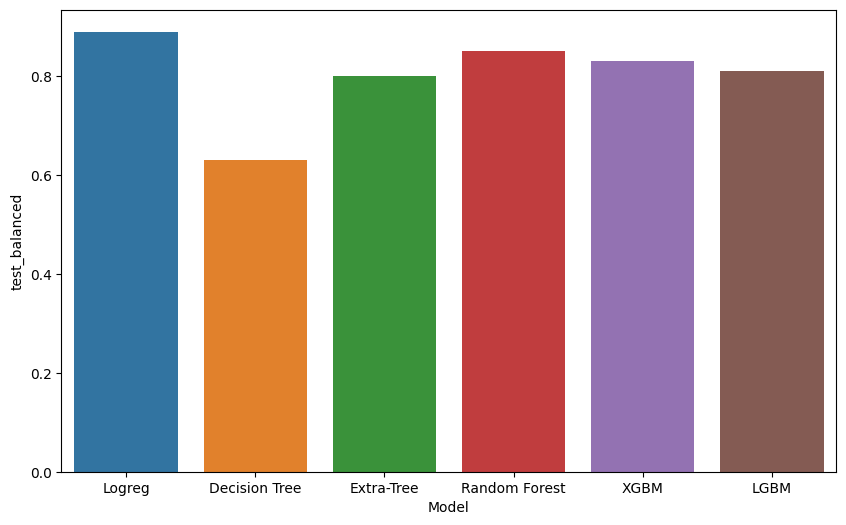

In [22]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Model', y= 'test_balanced',data=data_results)